**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import pickle
%matplotlib inline

In [2]:
# Load calibration images.

obj_points = []
img_points = []
out_images = []
raw_images = []

objp = np.zeros((6*9,3), np.float32) 
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x and y cordinates.

for img_filename in glob.glob('./camera_cal/*.jpg'):
    image = cv2.imread(img_filename)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    pattern_found, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if pattern_found == True:
        img_points.append(corners)
        obj_points.append(objp)

        out_image = cv2.drawChessboardCorners(image.copy(), (9,6), corners, pattern_found)
        out_images.append(out_image)
        raw_images.append(image)


In [3]:
def show(img, title='', figsize=(10, 10)):
    plt.figure(figsize=figsize)
    plt.subplot(1, 1, 1)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()

def side_by_side(img1, img2, title1='Original', title2='', cmap='gray', figsize=(15, 30)):
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.imshow(img1, cmap=cmap)
    plt.title(title1)
    plt.subplot(1, 2, 2)
    plt.imshow(img2, cmap=cmap)
    plt.title(title2)
    plt.show()
    
def side_by_side3(img1, img2, img3, title1='Original', title2='', title3='', cmap='gray', figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.subplot(1, 3, 1)
    plt.imshow(img1, cmap=cmap)
    plt.title(title1)
    plt.subplot(1, 3, 2)
    plt.imshow(img2, cmap=cmap)
    plt.title(title2)
    plt.subplot(1, 3, 3)
    plt.imshow(img3, cmap=cmap)
    plt.title(title3)
    plt.show()

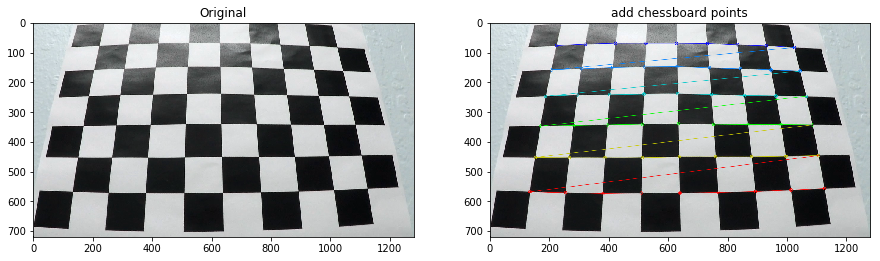

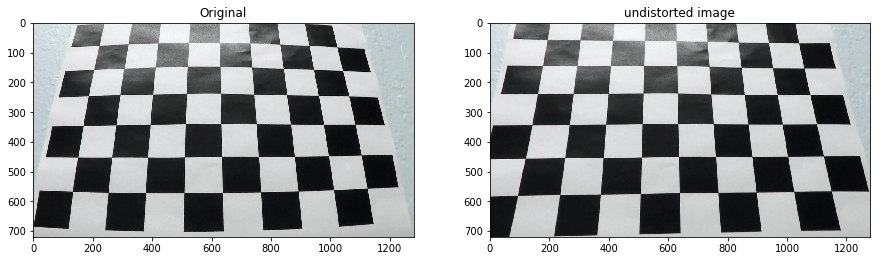

{'mtx': array([[1.15777942e+03, 0.00000000e+00, 6.67111050e+02],
       [0.00000000e+00, 1.15282305e+03, 3.86129069e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]), 'dist': array([[-0.24688833, -0.02372816, -0.00109843,  0.00035105, -0.00259135]])}


In [4]:
# Show points
img_idx = 0
side_by_side(raw_images[img_idx], out_images[img_idx], title2='add chessboard points')

# Undistort
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, raw_images[img_idx].shape[0:2], None, None)
undistorted_images = cv2.undistort(raw_images[img_idx], mtx, dist, None, mtx)
side_by_side(raw_images[img_idx], undistorted_images, title2='undistorted image')

print({ 'mtx': mtx, 'dist': dist })

## Apply a distortion correction to raw images.

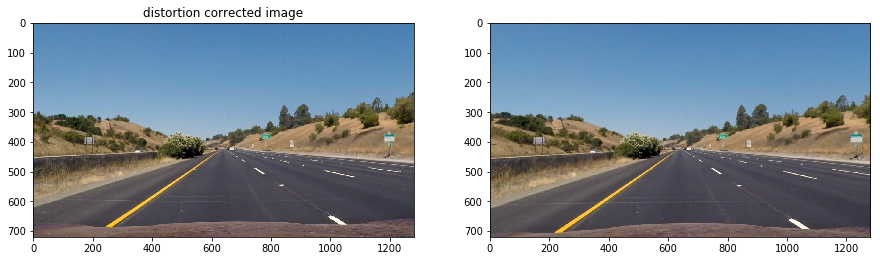

In [5]:
# Load test images.
test_images = []
fixed_images = []

# Correct distortion.
for img_filename in glob.glob('./test_images/*.jpg'):
    test_image = cv2.imread(img_filename)
    test_images.append(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
    fixed_image = cv2.cvtColor(cv2.undistort(test_image, mtx, dist, None, mtx), cv2.COLOR_BGR2RGB)
    fixed_images.append(fixed_image)
    
img_idx = 3
side_by_side(test_images[img_idx], fixed_images[img_idx], 'distortion corrected image')


# Use color transforms, gradients, etc., to create a thresholded binary image.

### Compare different color space

RGB Image by Band (R, G, B)


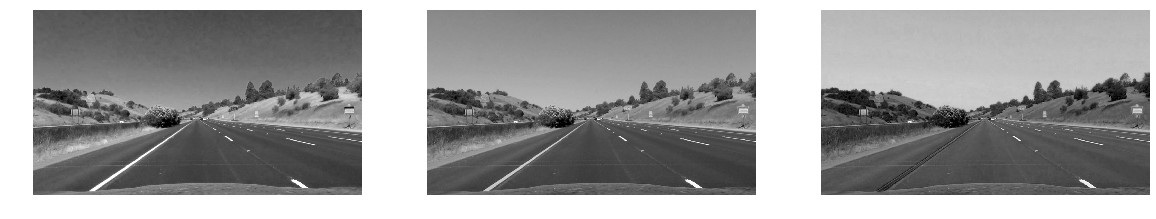

HLS Image by Band (H, L, S)


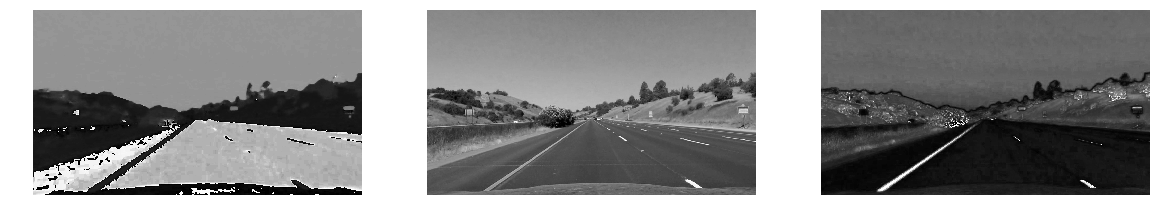

In [6]:
# HLS
img_idx = 3
rgb_img = fixed_images[img_idx]
hls_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)

print('RGB Image by Band (R, G, B)')
fig, axes = plt.subplots(ncols=3, figsize=(20,10))
for band, a in enumerate(axes):
    a.imshow(rgb_img[:,:,band], cmap='gray')
    a.axis('off')
plt.show()

print('HLS Image by Band (H, L, S)')
fig, axes = plt.subplots(ncols=3, figsize=(20,10))
for band, a in enumerate(axes):
    a.imshow(hls_img[:,:,band], cmap='gray')
    a.axis('off')
plt.show()

# It seems S band is good for detection the line.

In [7]:
def apply_sobel_threshold_on_s(rgb_img, orient='x', sobel_kernel=3, min_threshold=10, max_threshold=150):
    if orient == 'x':
        yorder = 0
        xorder = 1
    else:
        yorder = 1
        xorder = 0
        
    # apply sobel on s band.
    hls = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)
    s_band = hls[:, :, 2]
    sobel = cv2.Sobel(s_band, cv2.CV_64F, xorder, yorder, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled = np.uint8(255.0*abs_sobel/np.max(abs_sobel))
    
    # apply threshold to get a binary mask
    bin_mask = np.zeros_like(scaled)
    bin_mask[(scaled >= min_threshold) & (scaled <= max_threshold)] = 1
    
    return bin_mask

def compare_sobel(img_idx, sobel_kernel=3, min_threshold=10, max_threshold=150):
    rgb_img = fixed_images[img_idx]
    sobel_mask_x = apply_sobel_threshold_on_s(
        rgb_img, orient='x', sobel_kernel=sobel_kernel,
        min_threshold=min_threshold, max_threshold=max_threshold)
    sobel_mask_y = apply_sobel_threshold_on_s(
        rgb_img, orient='y', sobel_kernel=sobel_kernel,
        min_threshold=min_threshold, max_threshold=max_threshold)
    side_by_side(sobel_mask_x, sobel_mask_y, 'Sobel on S on X direction', 'Sobel on S on Y direction')


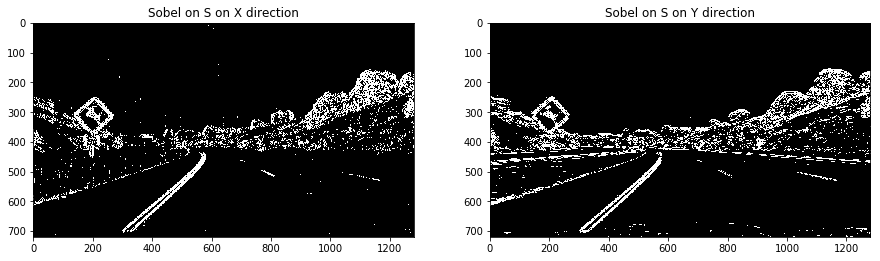

In [8]:
compare_sobel(0, sobel_kernel=3, min_threshold=10, max_threshold=150)

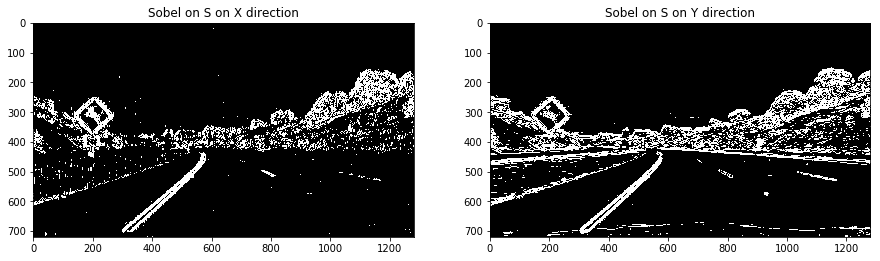

In [9]:
compare_sobel(0, sobel_kernel=7, min_threshold=10, max_threshold=150)

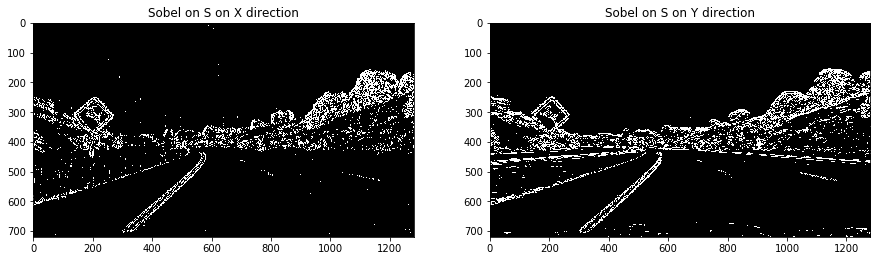

In [10]:
compare_sobel(0, min_threshold=10, max_threshold=50)

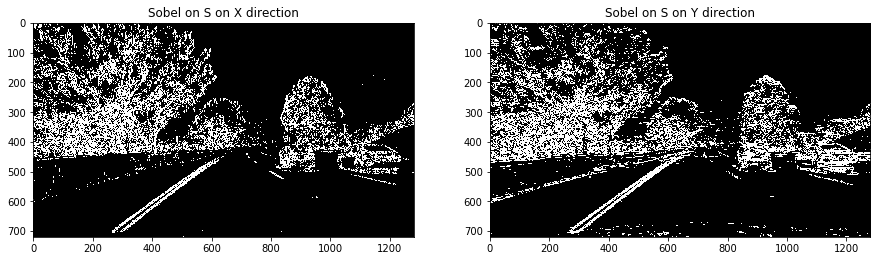

In [11]:
compare_sobel(5, min_threshold=10, max_threshold=150)

### Gradient Scale

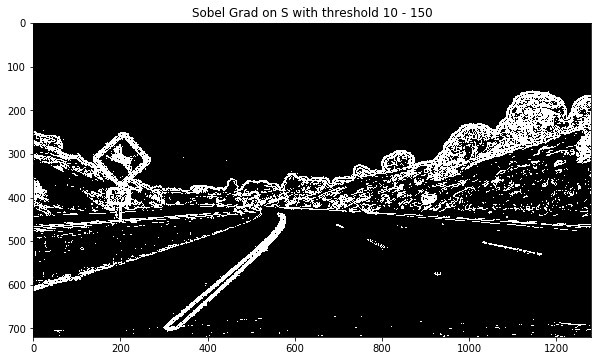

In [12]:
def apply_sobel_gradient_threshold_on_s(rgb_img, sobel_kernel=3, min_threshold=10, max_threshold=150):
    # apply sobel on s band.
    hls = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)
    s_band = hls[:, :, 2]
    sobelx = cv2.Sobel(s_band, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(s_band, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    grad = np.sqrt(sobelx**2 + sobely**2)
    scaled_grad = (255.0 * grad/np.max(grad)).astype(np.uint8) 
    
    # apply threshold to get a binary mask
    bin_mask = np.zeros_like(scaled_grad)
    bin_mask[(scaled_grad >= min_threshold) & (scaled_grad <= max_threshold)] = 1
    
    return bin_mask

def compare_sobel_grad(img_idx, sobel_kernel=3, min_threshold=10, max_threshold=150):
    rgb_img = fixed_images[img_idx]
    grad_mask = apply_sobel_gradient_threshold_on_s(
        rgb_img, sobel_kernel=sobel_kernel,
        min_threshold=min_threshold, max_threshold=max_threshold)
    show(grad_mask, 'Sobel Grad on S with threshold %d - %d' % ( min_threshold, max_threshold))
    

compare_sobel_grad(0)

### Gradient direction

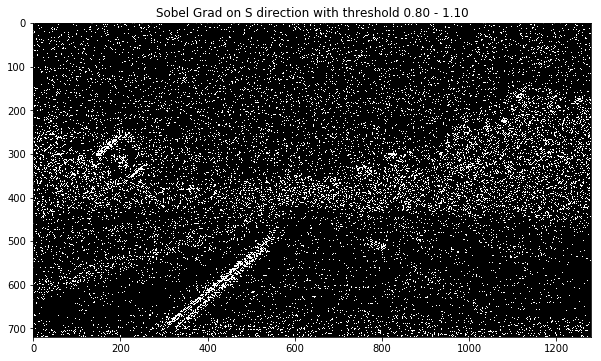

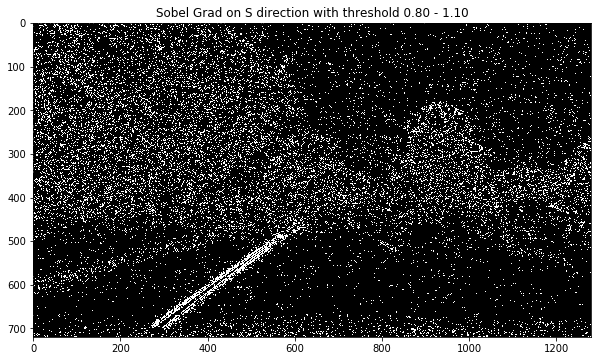

In [13]:
def apply_sobel_gradient_direction_threshold_on_s(
    rgb_img, sobel_kernel=3, min_threshold=0.8, max_threshold=1.1):
    # apply sobel on s band.
    hls = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)
    s_band = hls[:, :, 2]
    sobelx = cv2.Sobel(s_band, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(s_band, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_grad_direction = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    # apply threshold to get a binary mask
    bin_mask = np.zeros_like(abs_grad_direction)
    bin_mask[(abs_grad_direction >= min_threshold) & (abs_grad_direction <= max_threshold)] = 1
    
    return bin_mask

def compare_sobel_grad_direction(img_idx, sobel_kernel=3, min_threshold=10, max_threshold=160):
    rgb_img = fixed_images[img_idx]
    grad_mask = apply_sobel_gradient_direction_threshold_on_s(
        rgb_img, sobel_kernel=sobel_kernel,
        min_threshold=min_threshold, max_threshold=max_threshold)
    show(grad_mask, 'Sobel Grad on S direction with threshold %.2f - %.2f' % ( min_threshold, max_threshold))

compare_sobel_grad_direction(0, min_threshold=0.8, max_threshold=1.1)
compare_sobel_grad_direction(5, min_threshold=0.8, max_threshold=1.1)

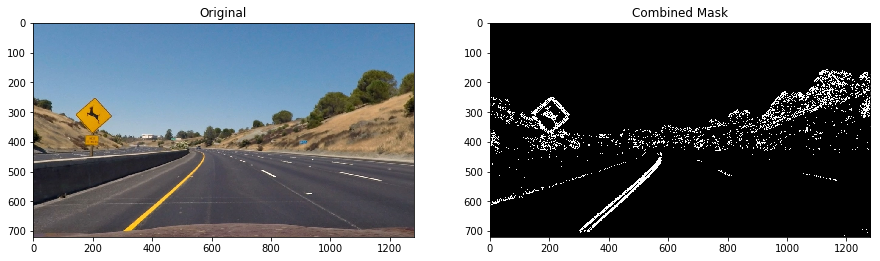

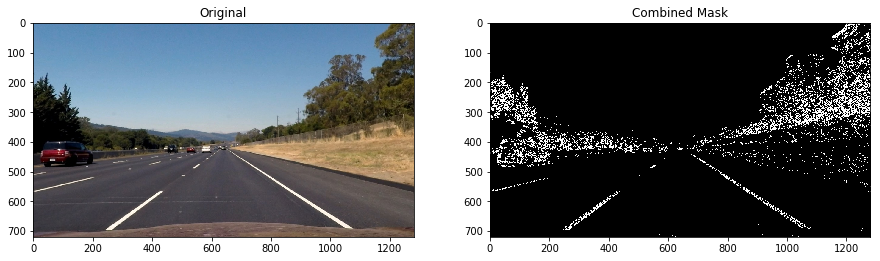

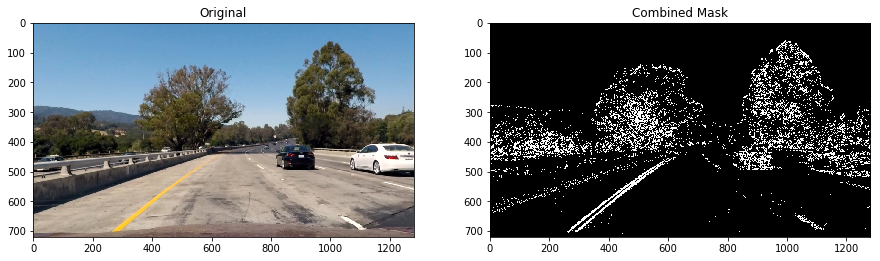

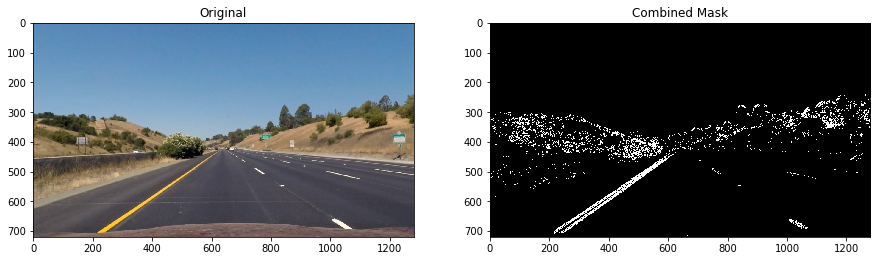

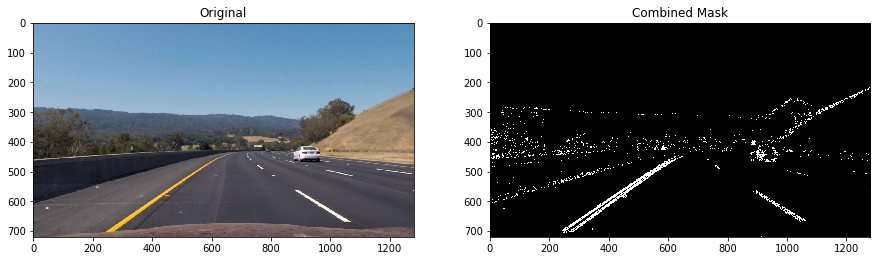

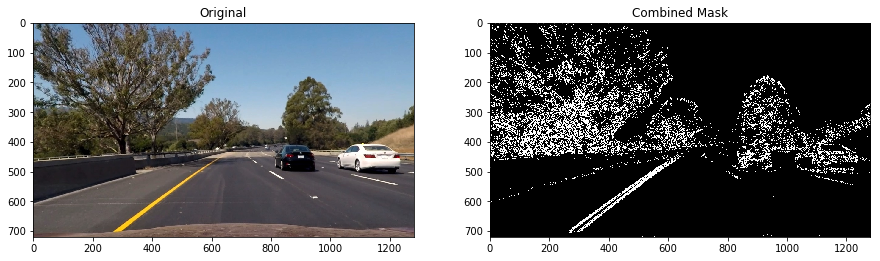

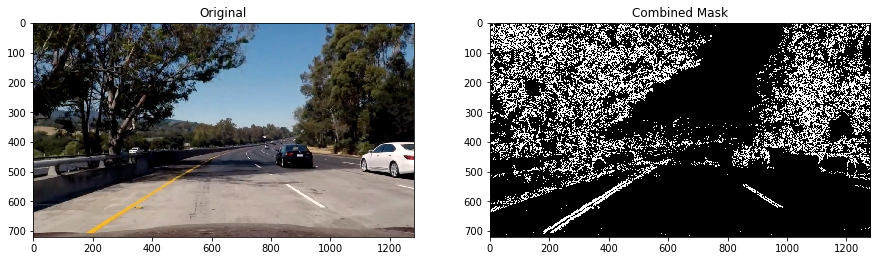

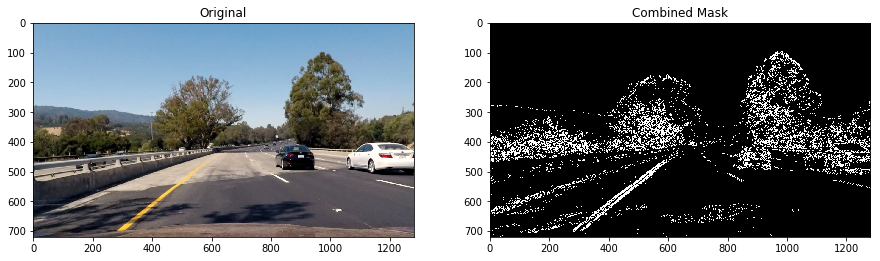

In [14]:
def combined_mask(img):
    """Combine all the masks of the image."""
    sobel_x = apply_sobel_threshold_on_s(img, 'x')
    sobel_y = apply_sobel_threshold_on_s(img, 'y')
    grad = apply_sobel_gradient_threshold_on_s(img)
    grad_direction = apply_sobel_gradient_direction_threshold_on_s(img)
    combined = np.zeros_like(grad) 
    combined[((sobel_x == 1) & (sobel_y == 1)) | ((grad == 1) & (grad_direction == 1))] = 1
    return combined

combined_masks = []
for img_idx in range(len(fixed_images)):
    img = fixed_images[img_idx]
    mask = combined_mask(img)
    combined_masks.append(mask)

for img_idx in range(len(fixed_images)):
    side_by_side(fixed_images[img_idx], combined_masks[img_idx], 'Original', 'Combined Mask')

## Apply a perspective transform to rectify binary image ("birds-eye view").

(720, 1280, 3)


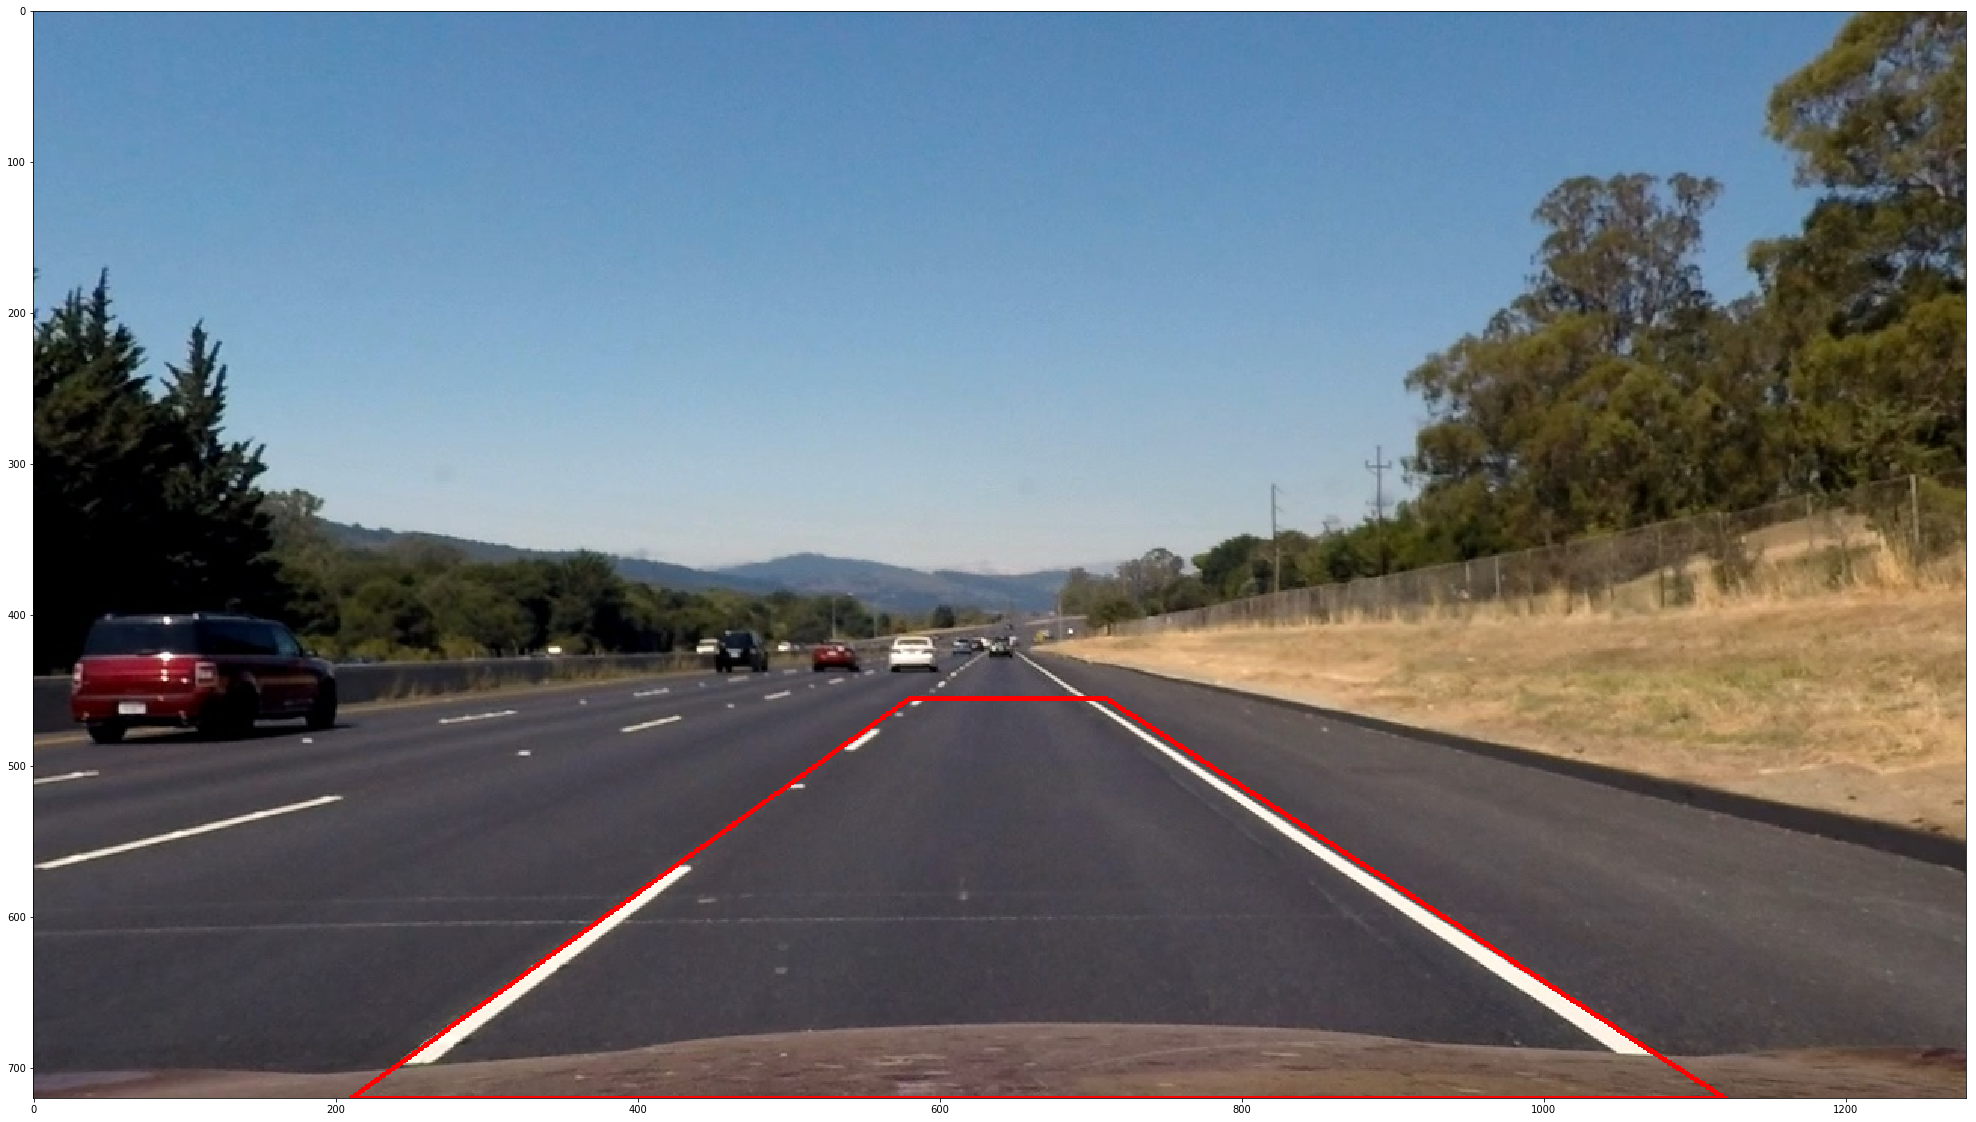

In [15]:
# Check the box.
img_idx = 1
undist_img = fixed_images[img_idx]
print(undist_img.shape)
img_copy = undist_img.copy()

bottom_y = 720
top_y = 455

left1 = (210, bottom_y)
left1_x, left1_y = left1
left2 = (580, top_y)
left2_x, left2_y = left2

right1 = (710, top_y)
right1_x, right1_y = right1

right2 = (1120, bottom_y)
right2_x, right2_y = right2

color = [255, 0, 0]
w = 2
cv2.line(img_copy, left1, left2, color, w)
cv2.line(img_copy, left2, right1, color, w)
cv2.line(img_copy, right1, right2, color, w)
cv2.line(img_copy, right2, left1, color, w)
fig, ax = plt.subplots(figsize=(40, 20))
ax.imshow(img_copy)

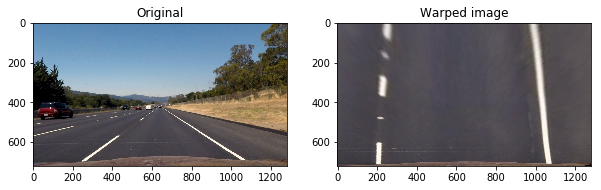

M =
 [[-7.27726634e-01 -1.50288657e+00  1.08439382e+03]
 [ 6.09036631e-16 -2.04462475e+00  9.30304260e+02]
 [ 1.17445080e-18 -2.43407708e-03  1.00000000e+00]]
Minv =
 [[ 1.47727273e-01 -7.63888889e-01  5.50454545e+02]
 [-1.52724729e-16 -4.89087302e-01  4.55000000e+02]
 [-2.19982271e-19 -1.19047619e-03  1.00000000e+00]]


In [16]:
gray = cv2.cvtColor(undist_img, cv2.COLOR_BGR2GRAY)
src = np.float32([ 
    [left2_x, left2_y],
    [right1_x, right1_y],
    [right2_x, right2_y],
    [left1_x, left1_y]
])
img_size = (gray.shape[1], gray.shape[0])
offset = 200
dst = np.float32([
    [offset, 0],
    [img_size[0]-offset, 0],
    [img_size[0]-offset, img_size[1]], 
    [offset, img_size[1]]
])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(undist_img, M, img_size)

side_by_side(undist_img, warped, 'Original', 'Warped image', figsize=(10, 4))
print('M =\n', M)
print('Minv =\n', Minv)

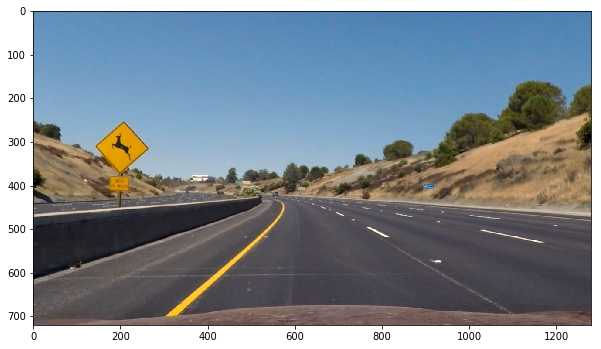

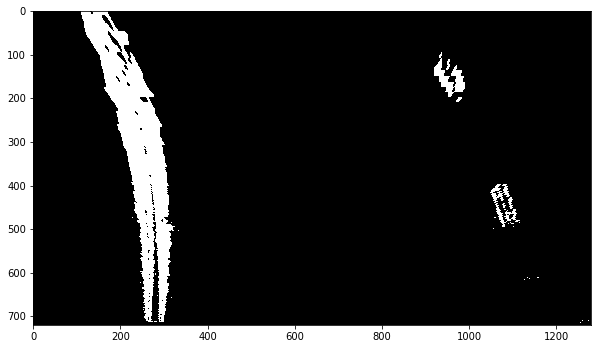

In [17]:
# Get warped mask from raw rgb image
def get_warp_mask(img):
    mask = combined_mask(img)
    img_size = (img.shape[1], img.shape[0])
    warped_mask = cv2.warpPerspective(mask, M, img_size)
    return warped_mask

show(fixed_images[0])
show(get_warp_mask(fixed_images[0]))

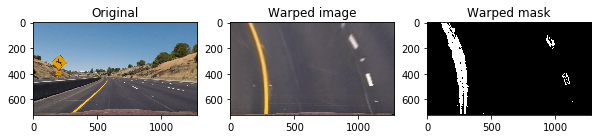

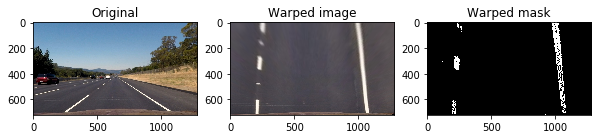

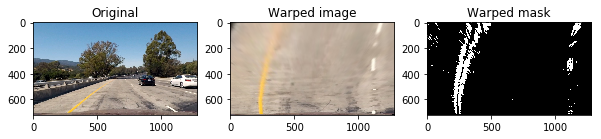

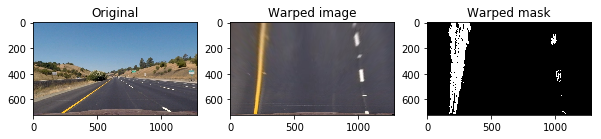

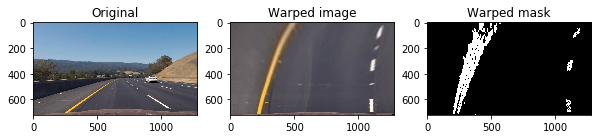

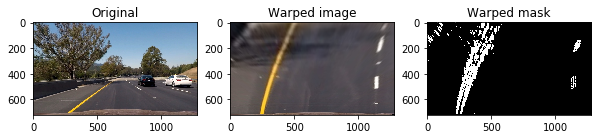

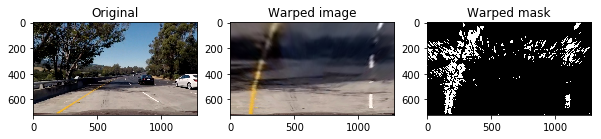

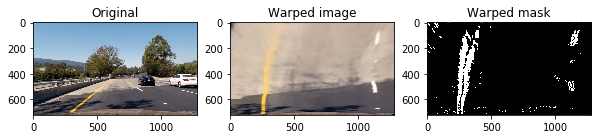

In [18]:
warped_images = []
for img in fixed_images:
    img_size = (img.shape[1], img.shape[0])
    warped_img = cv2.warpPerspective(img, M, img_size)
    warped_images.append(warped_img)

warped_masks = []
for img in combined_masks:
    img_size = (img.shape[1], img.shape[0])
    warped_mask = cv2.warpPerspective(img, M, img_size)
    warped_masks.append(warped_mask)

for img_idx in range(len(fixed_images)):
    side_by_side3(fixed_images[img_idx], warped_images[img_idx], warped_masks[img_idx], 'Original', 'Warped image', 'Warped mask',
                  figsize=(10, 4))

## Detect lane pixels and fit to find the lane boundary.

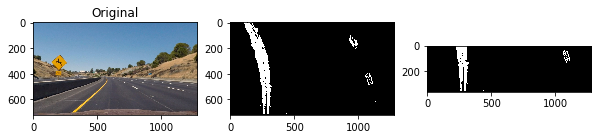

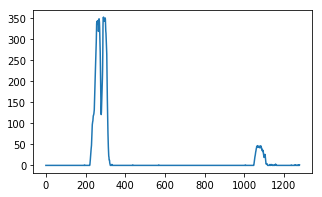

left lane: 291 right lane 1067


In [19]:
# Get histogram of the bottom half mask.

def test_hist(img_idx):
    fixed_img, warp_img, warp_mask = fixed_images[img_idx], warped_images[img_idx], warped_masks[img_idx]
    img_height = warp_mask.shape[0]
    img_width = warp_mask.shape[1]
    midpoint_y = img_height // 2
    midpoint_x = img_width // 2
    histogram = np.sum(warp_mask[midpoint_y:, :], axis=0)
    leftx_base = np.argmax(histogram[:midpoint_x])
    rightx_base = np.argmax(histogram[midpoint_x:]) + midpoint_x

    side_by_side3(fixed_img, warp_mask, warp_mask[midpoint_y:, :], figsize=(10,10))
    plt.figure(figsize=(5,3))
    plt.subplot(1, 1, 1)
    plt.plot(histogram)
    plt.show()

    print('left lane:', leftx_base, 'right lane', rightx_base)

test_hist(0)

In [20]:
# Convert pixel to meters and fit again.
ym_per_pix = 30/720  # meters per pixel in y dimension
xm_per_pix = 3.7/700  # meters per pixel in x dimension

# Find the line in the mask.
# Args:
#   img_idx: image index
#   img: If img_idx is None, you should pass the actual rgb img here.
#   nwindows: number of windows to split the image vertically
#   margin: the margin on x
#   min_pixels: minimum number of pixels to be considered
#   show: whether to show the plots.
def find_line_in_mask(img_idx=None, img=None, nwindows=8, margin=100, min_pixels=50, figsize=(5,5), show=True):   
    # Get images and masks.
    if img_idx is not None:
        warp_mask = warped_masks[img_idx]
    else:
        warp_mask = get_warp_mask(img)
    
    # Get the start point of the lanes.
    img_height = warp_mask.shape[0]
    img_width = warp_mask.shape[1]
    midpoint_y = img_height // 2
    midpoint_x = img_width // 2
    histogram = np.sum(warp_mask[midpoint_y:, :], axis=0)
    leftx_current = np.argmax(histogram[:midpoint_x])
    rightx_current = np.argmax(histogram[midpoint_x:]) + midpoint_x

    # Set height of windows
    window_height = np.int(img_height/nwindows)
    # Find the x and y positions of all nonzero pixels in the image
    nonzero = warp_mask.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = []
    right_lane_inds = []

    # Iterate the windows one by one
    out_img = np.dstack((warp_mask, warp_mask, warp_mask))*255
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img_height - (window+1)*window_height
        win_y_high = img_height - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the window
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Find the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Save the indices
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # update the center of lanes
        if len(good_left_inds) > min_pixels:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > min_pixels:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Visualization
    ploty = np.linspace(0, img_height-1, img_height)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    if show:
        plt.figure(figsize=figsize)
        plt.subplot(1, 1, 1)
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.show()
    
    return ploty, left_fit_m, right_fit_m, left_fit, right_fit

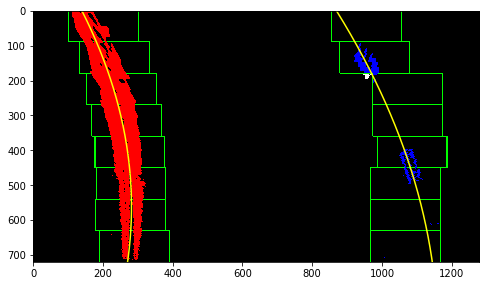

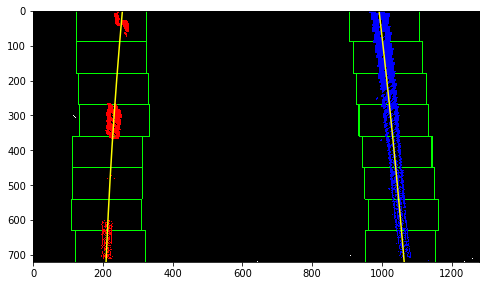

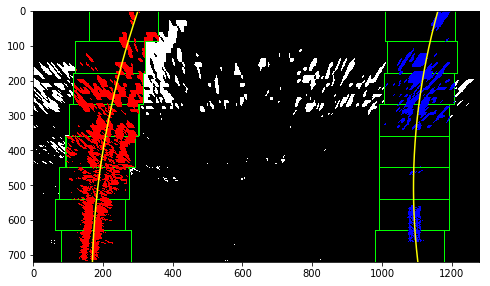

In [21]:
for i in [0, 1, 6]:
    find_line_in_mask(i, figsize=(8,8))

## Determine the curvature of the lane and vehicle position with respect to center.

In [22]:
def compute_curvature(img_idx=None, img=None):
    if img_idx is not None:
        ploty, left_fit_m, right_fit_m, left_fit, right_fit = find_line_in_mask(img_idx, figsize=(8,8), show=False)
    else:
        ploty, left_fit_m, right_fit_m, left_fit, right_fit = find_line_in_mask(img=img, figsize=(8,8), show=False)

    # compute the radius of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_m[0]*y_eval*ym_per_pix + left_fit_m[1])**2)**1.5) / np.absolute(2*left_fit_m[0]) / 1000
    right_curverad = ((1 + (2*right_fit_m[0]*y_eval*ym_per_pix + right_fit_m[1])**2)**1.5) / np.absolute(2*right_fit_m[0]) / 1000

    return left_curverad, right_curverad


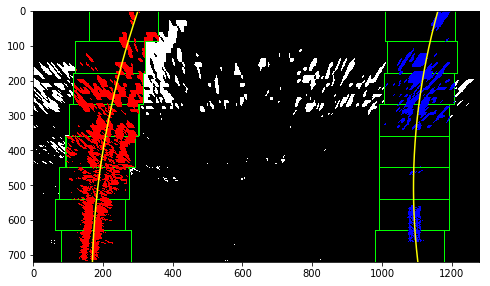

Curvature of image 6 : left 0.7604948637296846 km, right 0.6009473249775266 km


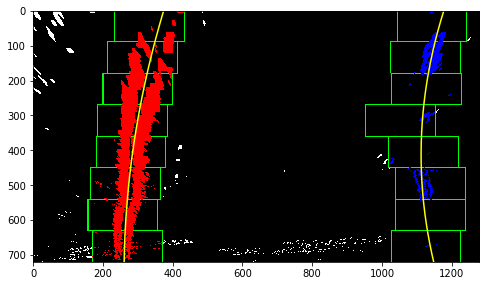

Curvature of image 7 : left 0.8351298828438802 km, right 0.4304509736110603 km


In [23]:
img_idx = 6
find_line_in_mask(6, figsize=(8,8))
left_curverad, right_curverad = compute_curvature(img_idx)
print('Curvature of image', img_idx, ': left', left_curverad, 'km, right', right_curverad, 'km')

img_idx = 7
img=fixed_images[img_idx]
find_line_in_mask(img=img, figsize=(8,8))
left_curverad, right_curverad = compute_curvature(img=img)
print('Curvature of image', img_idx, ': left', left_curverad, 'km, right', right_curverad, 'km')

## Warp the detected lane boundaries back onto the original image.

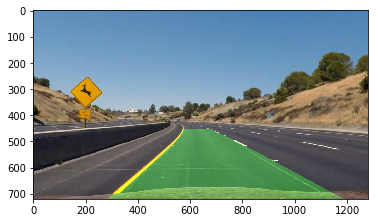

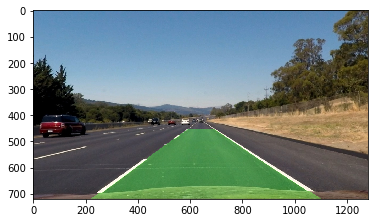

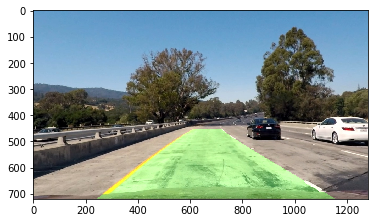

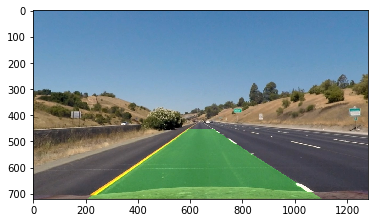

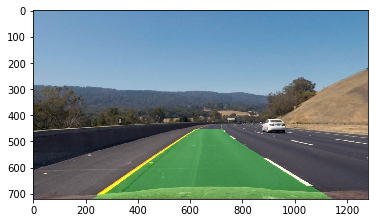

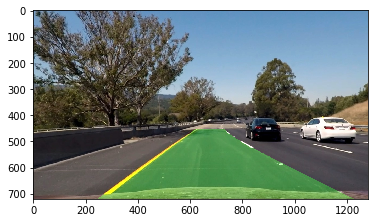

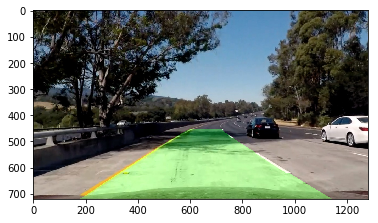

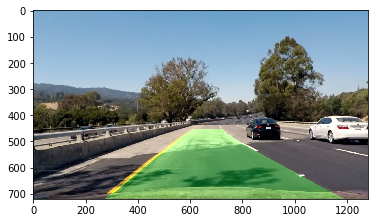

In [33]:
def draw_lane(img, show=True):
    ploty, left_fit_m, right_fit_m, left_fit, right_fit = find_line_in_mask(img=img, show=False)
    
    """Draw the lane lines and other overlays on the image"""
    mask = get_warp_mask(img)
    
    height = img.shape[0]
    ploty = np.linspace(0, height - 1, height)
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    output = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    if show:
        left_curverad, right_curverad = compute_curvature(img=img)
        xMax = img.shape[1]*xm_per_pix
        yMax = img.shape[0]*ym_per_pix
        vehicleCenter = xMax / 2
        lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
        lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
        lineMiddle = lineLeft + (lineRight - lineLeft)/2
        diffFromVehicle = lineMiddle - vehicleCenter
        if diffFromVehicle > 0:
            message = '{:.2f} m right'.format(diffFromVehicle)
        else:
            message = '{:.2f} m left'.format(-diffFromVehicle)
        print(message, left_curverad, right_curverad)
        # Draw info
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontColor = (255, 255, 255)
        fontScale = 2
        cv2.putText(output, 'Left curvature: %.2f km'%(left_curverad), (50, 50), font, fontScale, fontColor, 2)
        cv2.putText(output, 'Right curvature: %.2f km'%(right_curverad), (50, 120), font, fontScale, fontColor, 2)
        cv2.putText(output, 'Location: %s of center'%(message), (50, 190), font, fontScale, fontColor, 2)

    return output

for img_idx in range(8):
    img_with_lane = draw_lane(fixed_images[img_idx], show=False)
    show(img_with_lane, figsize=(6,6))

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

0.36 m right 0.3650224609477949 0.49602916310412004


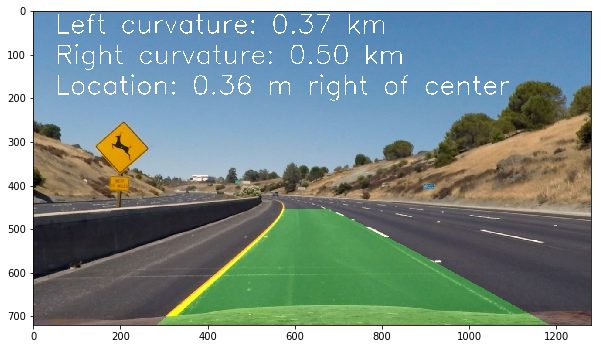

0.02 m left 0.7604948637296846 0.6009473249775266


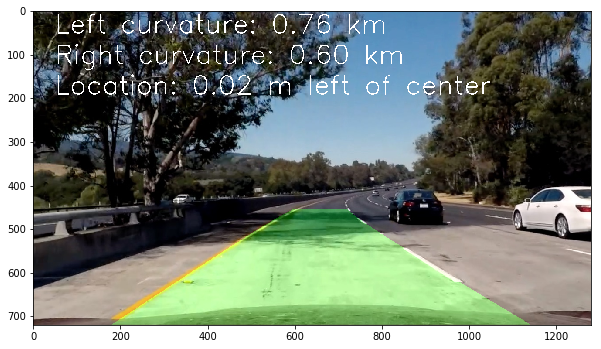

0.34 m right 0.8351298828438802 0.4304509736110603


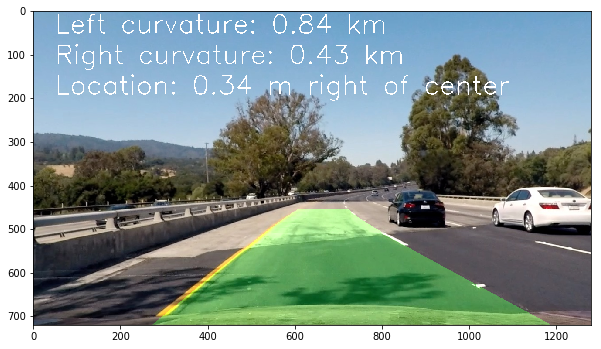

In [34]:
for img_idx in [0, 6, 7]:
    img_with_lane = draw_lane(fixed_images[img_idx], show=True)
    show(img_with_lane, figsize=(10,10))



## Generate video

In [37]:
from moviepy.editor import VideoFileClip
    
def generate_video(inputVideo, outputVideo):
    """
    Process the `inputVideo` frame by frame to find the lane lines, draw curvarute and vehicle position information and
    generate `outputVideo`
    """
    myclip = VideoFileClip(inputVideo)
    
    def processImage(img):
        return draw_lane(img, show=False)

    clip = myclip.fl_image(processImage)
    clip.write_videofile(outputVideo, audio=False)

# Project video
generate_video('project_video.mp4', 'annotated_video.mp4')

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video annotated_video.mp4.
Moviepy - Writing video annotated_video.mp4




t:  10%|▉         | 124/1260 [00:25<04:00,  4.72it/s, now=None]


t:  20%|█▉        | 246/1260 [00:50<03:25,  4.94it/s, now=None]


t:  29%|██▉       | 368/1260 [01:16<03:09,  4.71it/s, now=None]


t:  39%|███▉      | 490/1260 [01:42<02:45,  4.66it/s, now=None]


t:  49%|████▊     | 612/1260 [02:07<02:20,  4.61it/s, now=None]


t:  58%|█████▊    | 734/1260 [02:33<01:52,  4.68it/s, now=None]


t:  68%|██████▊   | 856/1260 [02:58<01:21,  4.96it/s, now=None]


t:  78%|███████▊  | 978/1260 [03:23<01:01,  4.62it/s, now=None]


t:  87%|████████▋ | 1098/1260 [03:48<00:33,  4.89it/s, now=None]


t:  97%|█████████▋| 1218/1260 [04:12<00:08,  4.77it/s, now=None]


t:   0%|          | 2/1260 [04:49<02:17,  9.13it/s, now=None]   

Moviepy - Done !
Moviepy - video ready annotated_video.mp4
